# Molecular Dynamics Simulation of Insulin-like Growth Factor-1 Receptor 

In [2]:
import numpy as np

import openmm as mm
from openmm import app
from openmm import unit
from openmmforcefields.generators import SMIRNOFFTemplateGenerator
from openff.toolkit.topology import Molecule
from pdbfixer import PDBFixer

from rdkit import Chem
from rdkit.Chem import AllChem

import nglview as nv
import mdtraj as md
from mdtraj.reporters import HDF5Reporter

from sys import stdout
import re
import requests
import os

## Download PDB 2OJ9

In [5]:
# Have look to https://bioportal.bioontology.org/ontologies/EDAM?p=classes&conceptid=data_1127
pattern= re.compile('[0-9][a-zA-Z_0-9]{3}')

def fetch_pdb(pdb_id, download_path="./"):
    
    if not pattern.match(pdb_id):
        raise ValueError("Invalid pdb id")
        
    url = 'http://files.rcsb.org/download/{}.pdb'.format(pdb_id)
    res = requests.get(url, allow_redirects=True)
    
    # I am not sure if a failed request raise an exception. The failing code is stored
    # in the attribute 'status_code'. For instance, if everything works properly:
    # res.status_code == 200
    
    if res.status_code != requests.codes.ok:
        print("Could not fetch pdb from {}".format(url))
        return 
        
    file_path = os.path.join(download_path, pdb_id + ".pdb")
    with open(file_path, "wb") as f:
        f.write(res.content)
        
fetch_pdb("2OJ9")

In [6]:
view = nv.show_structure_file("./2OJ9.pdb")
view

NGLWidget()

## Extract ligand and fix bond order

In [10]:
traj = md.load("./2OJ9.pdb")
topology = traj.topology
print(traj)
print(topology)

<mdtraj.Trajectory with 1 frames, 2592 atoms, 500 residues, and unitcells>
<mdtraj.Topology with 2 chains, 500 residues, 2592 atoms, 2443 bonds>


In [11]:
ligand = traj.atom_slice(topology.select("not water and not protein"))
print(ligand.topology)

view = nv.show_mdtraj(ligand)
view

<mdtraj.Topology with 1 chains, 1 residues, 30 atoms, 34 bonds>


NGLWidget()

In [12]:
ligand.save_pdb("./ligand.pdb")

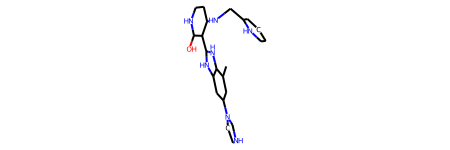

In [15]:
ligand_pdb = Chem.rdmolfiles.MolFromPDBFile("./ligand.pdb")
ligand_pdb

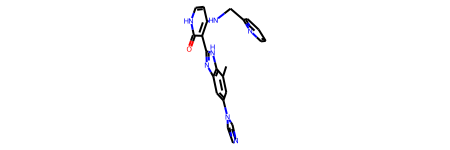

In [16]:
# Assing bond orders from smiles
template_mol = Chem.MolFromSmiles("Cc1cc(cc2c1[nH]c(n2)C3=C(C=CNC3=O)NCc4ccccn4)n5ccnc5")
ligand_fixed = AllChem.AssignBondOrdersFromTemplate(template_mol, ligand_pdb)
ligand_fixed

In [17]:
print(ligand_fixed.GetNumConformers())

1


In [18]:
# Add Hydrogens
ligand_H = Chem.AddHs(ligand_fixed, addCoords=True)
# Save ligand to file so openff can use it
writer = Chem.SDWriter("./ligand.sdf")
writer.write(ligand_H)
view = nv.show_rdkit(ligand_H)
view

NGLWidget()

## Extract Protein

In [19]:
protein_inxs = topology.select("protein")
protein_traj = traj.atom_slice(protein_inxs)
protein_topo = protein_traj.topology
print(protein_traj)
print(protein_topo)

<mdtraj.Trajectory with 1 frames, 2358 atoms, 295 residues, and unitcells>
<mdtraj.Topology with 1 chains, 295 residues, 2358 atoms, 2409 bonds>


In [20]:
view = nv.show_mdtraj(protein_traj)
view

NGLWidget()

In [22]:
# Save receptor to file
protein_traj.save_pdb("./protein.pdb")

## Fix Protein

In [23]:
protein_file = "./protein.pdb"
fixer = PDBFixer(filename=protein_file)

fixer.findMissingResidues()
missing_residues = fixer.missingResidues
fixer.findNonstandardResidues()
nonstandard_residues = fixer.nonstandardResidues
fixer.findMissingAtoms()
missing_atoms = fixer.missingAtoms
missing_terminals = fixer.missingTerminals
fixer.addMissingAtoms()

In [24]:
app.PDBFile.writeFile(fixer.topology, fixer.positions, open('protein_fixed_unsolvated.pdb', 'w'))

## Join ligand and protein, protonate and solvate system

In [3]:
protein_file = "./protein_fixed_unsolvated.pdb"
protein = app.PDBFile(protein_file)

In [4]:
modeller = app.Modeller(protein.topology, protein.positions)

ligand_file = "./ligand.sdf"
ligand = Molecule.from_file(ligand_file)
ligand_positions = ligand.conformers[0]
ligand_topology = ligand.to_topology()
modeller.add(ligand_topology.to_openmm(), ligand_positions)

### Load the forcefield

In [5]:
forcefield = app.ForceField("amber14-all.xml", "amber14/tip3p.xml")
smirnoff = SMIRNOFFTemplateGenerator(forcefield="openff-1.3.0.offxml", molecules=[ligand])
forcefield.registerTemplateGenerator(smirnoff.generator)

### Protonate

In [6]:
residues_protonated = modeller.addHydrogens(forcefield=forcefield, pH=7.2)

/bin/bash: /home/daniel/miniconda3/envs/cheminformatics/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/daniel/miniconda3/envs/cheminformatics/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/daniel/miniconda3/envs/cheminformatics/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/daniel/miniconda3/envs/cheminformatics/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/daniel/miniconda3/envs/cheminformatics/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/daniel/miniconda3/envs/cheminformatics/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### Solvate

In [7]:
clearance = 14*unit.angstroms
max_size = max(max((pos[i] for pos in modeller.positions))-min((pos[i] for pos in modeller.positions)) for i in range(3))
vectors = mm.Vec3(1.0, 0, 0), mm.Vec3(1.0/3.0, 2.0*np.sqrt(2.0)/3.0,0.0), mm.Vec3(-1.0/3.0, np.sqrt(2.0)/3.0, np.sqrt(6.0)/3.0)
box_vectors = [(max_size + clearance)*v for v in vectors]

modeller.addSolvent(forcefield, model='tip3p', boxVectors = box_vectors, neutralize=True)

In [8]:
# Verify that water and ions were added
n_waters = 0
ions = []
for chain in modeller.topology.chains():
    for residue in chain.residues():
        if residue.name=='HOH':
            n_waters += 1
        if len(list(residue.atoms()))==1:
            ions += [atom.name for atom in residue.atoms()]            

print('n_waters: {}'.format(n_waters))
print('ions: {}'.format(ions))

n_waters: 9245
ions: ['Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na']


## Create system and minimize energy

In [9]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometer,
                                 constraints=app.HBonds, rigidWater=True)

for force_index in range(system.getNumForces()):
    force = system.getForce(force_index)
    if isinstance(force, mm.NonbondedForce):
        nonbondedForce = force

nonbondedForce.setUseDispersionCorrection(True)
nonbondedForce.setEwaldErrorTolerance(1.0e-5)
nonbondedForce.setUseSwitchingFunction(True)
nonbondedForce.setSwitchingDistance(0.8*unit.nanometer)

In [10]:
platform = mm.Platform.getPlatformByName('CUDA')

integration_timestep = 2.0*unit.femtoseconds
temperature = 300.0*unit.kelvin

integrator = mm.LangevinIntegrator(temperature, 1.0/unit.picosecond, integration_timestep)

In [11]:
simulation = app.Simulation(modeller.topology, system, integrator, platform)

In [12]:
simulation.context.setPositions(modeller.positions)

### Energy Minimization

In [13]:
# Check the potential energy before minimization
initial_state = simulation.context.getState(getEnergy=True)
initial_state.getPotentialEnergy()

Quantity(value=239963410516042.78, unit=kilojoule/mole)

In [14]:
simulation.minimizeEnergy()

In [15]:
# Check the potential energy after minimization
minimized_state = simulation.context.getState(getEnergy=True)
minimized_state.getPotentialEnergy()

Quantity(value=-511521.9686954641, unit=kilojoule/mole)

In [16]:
# Writing out the minimized system
minimized_positions = simulation.context.getState(getPositions=True).getPositions()
app.PDBFile.writeFile(simulation.topology, minimized_positions, open('initial.pdb', 'w'))

### Visualized Mimimized system

In [17]:
view = nv.show_structure_file("initial.pdb")
view.add_licorice(selection="(not protein)")
view

NGLWidget()

## Simulation

In [18]:
simulation.context.setVelocitiesToTemperature(temperature)

In [19]:
simulation_time = 20000.0*unit.picoseconds
reporting_time = 20.0*unit.picoseconds
saving_time = 10.0*unit.picoseconds

simulation_steps = int(simulation_time/integration_timestep)
reporting_steps = int(reporting_time/integration_timestep)
saving_steps = int(saving_time/integration_timestep)

print(f"{simulation_steps} steps")
print(f"{reporting_steps} reporting steps")
print(f"{saving_steps} saving steps")

10000000 steps
10000 reporting steps
5000 saving steps


In [21]:
states_reporter = app.StateDataReporter(stdout, reporting_steps, step=True, potentialEnergy=True, temperature=True,
                                    progress=True, totalSteps=simulation_steps, speed=True, remainingTime=True)
traj_reporter = HDF5Reporter('traj.h5', saving_steps, coordinates=True, time=True, cell=True, potentialEnergy=True,
                             kineticEnergy=True, temperature=True)
checkpoint_reporter = app.CheckpointReporter("./checkpoint.chk", 500000)
simulation.reporters+=[states_reporter, traj_reporter, checkpoint_reporter]

In [22]:
simulation.step(simulation_steps)

#"Progress (%)","Step","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)","Time Remaining"
0.1%,10000,-410066.2186954641,301.6491712185183,0,--
0.2%,20000,-411725.2186954641,302.31166837194814,21.3,22:28:45
0.3%,30000,-410267.2186954641,298.84243706622374,21.3,22:26:10
0.4%,40000,-410037.2186954641,300.2408939672153,21.3,22:24:31
0.5%,50000,-410210.2186954641,298.8646178450507,21.3,22:23:05
0.6%,60000,-410729.7186954641,303.51863370648465,21.3,22:21:11
0.7%,70000,-411464.7186954641,300.4690905695422,21.4,22:17:03
0.8%,80000,-412595.2186954641,300.3203996541884,21.4,22:13:45
0.9%,90000,-411832.2186954641,299.8777205918102,21.4,22:10:55
1.0%,100000,-410960.2186954641,301.1849416854949,21.5,22:08:26
1.1%,110000,-410842.2186954641,297.9397008116793,21.5,22:06:11
1.2%,120000,-411225.4686954641,297.1691219259316,21.5,22:04:05
1.3%,130000,-410722.2186954641,298.8854816486194,21.5,22:02:05
1.4%,140000,-410089.4686954641,297.8403791388005,21.5,22:00:10
1.5%,150000,-412182.218695464

In [1]:
traj_reporter.close()

NameError: name 'traj_reporter' is not defined

In [24]:
# Writing out the final system
final_positions = simulation.context.getState(getPositions=True).getPositions()
app.PDBFile.writeFile(simulation.topology, final_positions, open('final.pdb', 'w'))

## Load From Checkpoint 

In [ ]:
#with open('checkpoint.chk', 'rb') as f:
#     simulation.context.loadCheckpoint(f.read())

In [ ]:
#simulation.step(simulation_steps)

### Visualizing Simulation

In [26]:
traj = md.load("traj.h5")
view = nv.show_mdtraj(traj)
#view.add_licorice(selection="(not protein)") # View water molecules
view

NGLWidget(max_frame=1999)